## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random variable $\mathsf{X} \in \mathbb{R}^{N_x}$ with density $\pi$ based on i.i.d. samples $\{\boldsymbol{x}^i\}, \; i = 1, \ldots, N_e$ from $\pi$.

Baptista et al.[3] showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2  \right] = \int |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2 \pi(\boldsymbol{x}) \; \mathrm{d}\boldsymbol{x}.
\end{equation}

The pullback density $\boldsymbol{S}^{\sharp} \rho$ can be used to approximate the true density $\pi$, where $\rho$ denotes the standard Gaussian distribution of $\mathbb{R}^n$. Thus, the score matrix is estimated by [3]: 
\begin{equation}
\hat{\Omega}_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \boldsymbol{S}^{\sharp} \rho|^2  \right]
\end{equation}

In practice, we use a sampled-based approximation $\hat{\boldsymbol{\Omega}}$ from the samples $\{\boldsymbol{x}^i\}, \; i=1,\ldots, N_e$ of $\pi$:


\begin{equation}
\hat{\Omega}_{i,j} \approx \sum_{k=1}^{N_e}|\partial_i\partial_j \log \boldsymbol{S}^{\sharp}\rho(\boldsymbol{x}^k )|^2
\end{equation}


We illustrate the estimation of the Hessian score on the invariant distribution (asymptotic distribution) of the Lorenz-96 model. The Lorenz-96 model [1] is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the twenty-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{20})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.


References: 

[1] Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).

[2] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[3] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter

Load some packages to make nice figures

In [2]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)

using LaTeXStrings

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


To generate i.i.d. samples from the invariant distribution of the Lorenz-96 problem, we sample $N_e$ from the standard normal distribution (i.e. with zero mean and identity covariance matrix). For each initial condition (i.e. for each sample), we solve the set of ODEs of the Lorenz-96 problem over  $Tsteps =  40,000$ steps using a fourth order Runge-Kutta method with a time-step of $\Delta t= 0.01$. The samples of the state at the final time can be considered as i.i.d. samples of the push-forward distribution of the standard Gaussian through the nonlinear forward dynamics for $Tstep$.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [3]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [4]:
# Define the distribution for initial condition
Nx = 20
# Number of runs
Ne = 500
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 20-element Vector{Float64}:
  0.8226753272716396
 -0.8762792785966129
  1.013218809029567
  0.8783148041196422
 -0.38408775455859084
 -0.5180597604723257
 -1.6361902534540735
 -0.8324116439245897
 -2.7983840965019504
  0.5396833277675798
  0.2812792355440235
  0.012976450691843971
 -0.5277781684746953
 -0.04695453495006433
 -0.29510946558395507
 -0.7335419382655867
  1.3191280088424162
  1.9619430593129126
 -2.1435503158191467
  0.7734200926859292

Create cache to store the different final solutions

In [5]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [6]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [7]:
m = 100
S = HermiteMap(m, X; diag = true, factor = 0.5, α = 1e-6, b = "ProHermiteBasis");

In [8]:
optimize(S, X, "kfold"; withqr = true, verbose = false, hessprecond = true)

Hermite map of dimension 20:
Hermite map component of dimension 1 with Nψ = 8 active features
Hermite map component of dimension 2 with Nψ = 15 active features
Hermite map component of dimension 3 with Nψ = 13 active features
Hermite map component of dimension 4 with Nψ = 17 active features
Hermite map component of dimension 5 with Nψ = 22 active features
Hermite map component of dimension 6 with Nψ = 16 active features
Hermite map component of dimension 7 with Nψ = 19 active features
Hermite map component of dimension 8 with Nψ = 19 active features
Hermite map component of dimension 9 with Nψ = 10 active features
Hermite map component of dimension 10 with Nψ = 20 active features
Hermite map component of dimension 11 with Nψ = 21 active features
Hermite map component of dimension 12 with Nψ = 13 active features
Hermite map component of dimension 13 with Nψ = 18 active features
Hermite map component of dimension 14 with Nψ = 15 active features
Hermite map component of dimension 15 with 

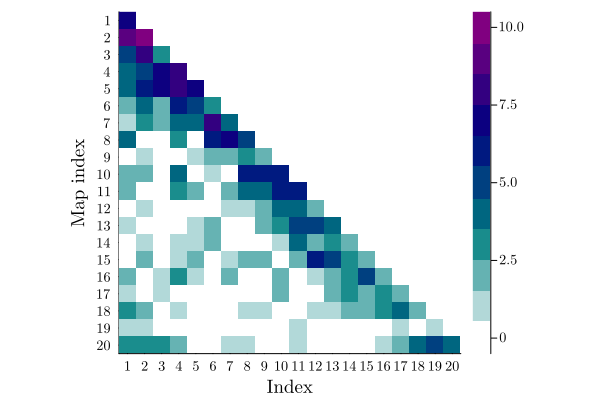

In [9]:
plot(S)
# savefig("Lorenz96_structure.pdf")

The function `hess_x_log_pdf!` computes in-place the Hessian of the log pdf of the pullback density $\boldsymbol{S}^{\sharp} \rho$. You can also use `hess_x_log_pdf`.

In [13]:
Ωhat = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


20×20 Matrix{Float64}:
     1.09724e7   14000.1        …      1.71243e5  48951.3
 14000.1             9.50742e6      4181.63           1.08954e6
  3932.62            2.27384e5      1748.35       28971.2
  9154.98       630620.0             297.225      74678.7
 44871.3          4134.1             441.767       1395.39
   536.485       17287.0        …    129.103         90.6384
  9106.96         7123.21            147.074      16000.7
  1139.03          628.755           118.92        4827.97
  7793.06        14418.0             123.395         60.1223
 14173.7          8472.15            153.379        171.87
  2124.74         2900.16       …   8432.5         4835.01
   936.296       10247.2             344.264         56.0211
  1593.71         1862.42            120.304         84.4966
 48645.1          4263.17            189.047        142.573
 10236.3         18128.1              49.3613       445.936
  3694.97        10985.3        …   1436.17       71471.6
 40982.3          1119.

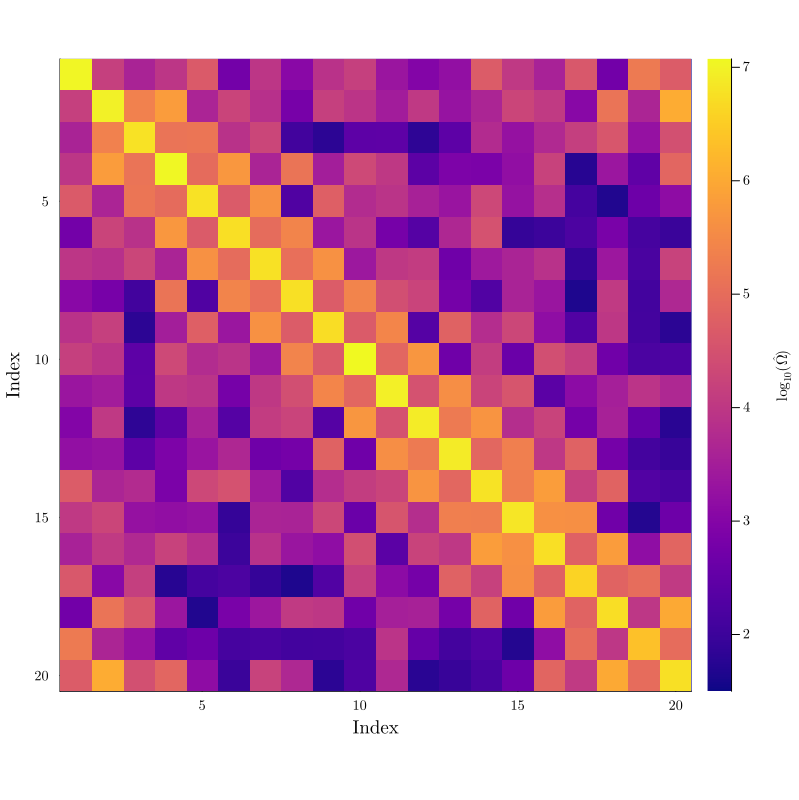

In [14]:
plt = plot(size = (800, 800))

heatmap!(plt,1:Nx, 1:Nx, log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1],
        ylims = (0.5,Nx+0.5))